To look at pySpark's GLM capabilities, we will use the simplest example of a gausian error distribution with an identity link function, which is equivalent to OLS.  In our model we'll try to answer a simple question: all else equal, how does a change in size (carat) affect a dimaond's price?  We will test the equation:

    price = a + B*carat + cut_dummy_vars + color_dummy_vars + clarity_dummy_vars + e
    
Don't worry about the accuracy of this model specification, or the assumptions behind it; our goal is just to compare pySpark's GLM function to something most users will be more familiar with.  Note that `cut`, `color` and `clarity` had to be converted to numeric because Stata can't work with strings.  This was done using, for example, `encode cut, gen(cut_)`.

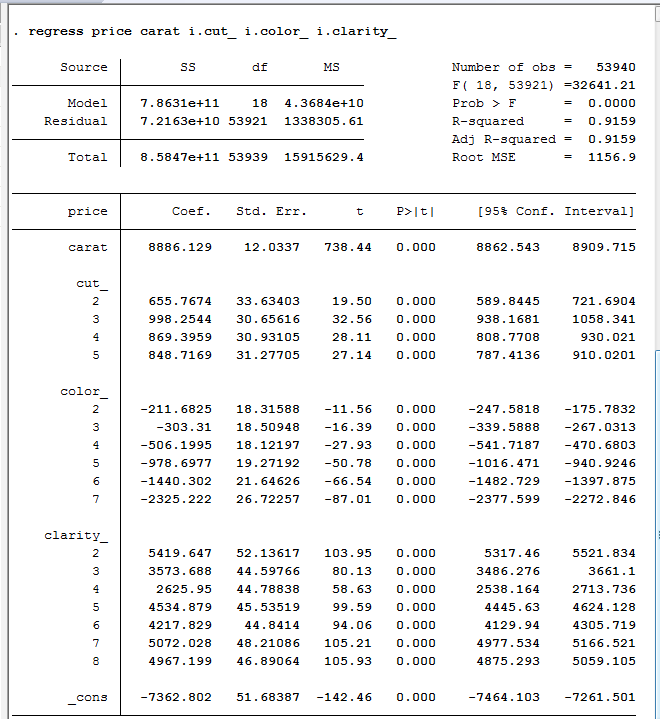

In [3]:
from IPython.display import Image
Image(filename='stata_regress.PNG')

Now to begin in pySpark we will import the same dataset used to make the Stata output:

In [1]:
df = spark.read.csv('s3://ui-spark-data/diamonds.csv', inferSchema=True, header=True, sep=',')

In [2]:
df.show()

+-----+---------+-----+-------+-----+-----+-----+----+----+----+
|carat|      cut|color|clarity|depth|table|price|   x|   y|   z|
+-----+---------+-----+-------+-----+-----+-----+----+----+----+
| 0.23|    Ideal|    E|    SI2| 61.5| 55.0|  326|3.95|3.98|2.43|
| 0.21|  Premium|    E|    SI1| 59.8| 61.0|  326|3.89|3.84|2.31|
| 0.23|     Good|    E|    VS1| 56.9| 65.0|  327|4.05|4.07|2.31|
| 0.29|  Premium|    I|    VS2| 62.4| 58.0|  334| 4.2|4.23|2.63|
| 0.31|     Good|    J|    SI2| 63.3| 58.0|  335|4.34|4.35|2.75|
| 0.24|Very Good|    J|   VVS2| 62.8| 57.0|  336|3.94|3.96|2.48|
| 0.24|Very Good|    I|   VVS1| 62.3| 57.0|  336|3.95|3.98|2.47|
| 0.26|Very Good|    H|    SI1| 61.9| 55.0|  337|4.07|4.11|2.53|
| 0.22|     Fair|    E|    VS2| 65.1| 61.0|  337|3.87|3.78|2.49|
| 0.23|Very Good|    H|    VS1| 59.4| 61.0|  338| 4.0|4.05|2.39|
|  0.3|     Good|    J|    SI1| 64.0| 55.0|  339|4.25|4.28|2.73|
| 0.23|    Ideal|    J|    VS1| 62.8| 56.0|  340|3.93| 3.9|2.46|
| 0.22|  Premium|    F|  

In [5]:
from pyspark.ml.feature import StringIndexer
stringIndexer = StringIndexer(inputCol="cut", outputCol="cut_index")
model = stringIndexer.fit(df)
indexed = model.transform(df)

In [12]:
indexed.show()

+-----+---------+-----+-------+-----+-----+-----+----+----+----+--------+
|carat|      cut|color|clarity|depth|table|price|   x|   y|   z|cutIndex|
+-----+---------+-----+-------+-----+-----+-----+----+----+----+--------+
| 0.23|    Ideal|    E|    SI2| 61.5| 55.0|  326|3.95|3.98|2.43|     0.0|
| 0.21|  Premium|    E|    SI1| 59.8| 61.0|  326|3.89|3.84|2.31|     1.0|
| 0.23|     Good|    E|    VS1| 56.9| 65.0|  327|4.05|4.07|2.31|     3.0|
| 0.29|  Premium|    I|    VS2| 62.4| 58.0|  334| 4.2|4.23|2.63|     1.0|
| 0.31|     Good|    J|    SI2| 63.3| 58.0|  335|4.34|4.35|2.75|     3.0|
| 0.24|Very Good|    J|   VVS2| 62.8| 57.0|  336|3.94|3.96|2.48|     2.0|
| 0.24|Very Good|    I|   VVS1| 62.3| 57.0|  336|3.95|3.98|2.47|     2.0|
| 0.26|Very Good|    H|    SI1| 61.9| 55.0|  337|4.07|4.11|2.53|     2.0|
| 0.22|     Fair|    E|    VS2| 65.1| 61.0|  337|3.87|3.78|2.49|     4.0|
| 0.23|Very Good|    H|    VS1| 59.4| 61.0|  338| 4.0|4.05|2.39|     2.0|
|  0.3|     Good|    J|    SI1| 64.0| 

In [14]:
from pyspark.ml.feature import OneHotEncoder
encoder = OneHotEncoder(dropLast=False, inputCol="cut_index", outputCol="cut_vector")
encoded = encoder.transform(indexed)

In [15]:
encoded.show()

+-----+---------+-----+-------+-----+-----+-----+----+----+----+--------+-------------+
|carat|      cut|color|clarity|depth|table|price|   x|   y|   z|cutIndex|       cutVec|
+-----+---------+-----+-------+-----+-----+-----+----+----+----+--------+-------------+
| 0.23|    Ideal|    E|    SI2| 61.5| 55.0|  326|3.95|3.98|2.43|     0.0|(5,[0],[1.0])|
| 0.21|  Premium|    E|    SI1| 59.8| 61.0|  326|3.89|3.84|2.31|     1.0|(5,[1],[1.0])|
| 0.23|     Good|    E|    VS1| 56.9| 65.0|  327|4.05|4.07|2.31|     3.0|(5,[3],[1.0])|
| 0.29|  Premium|    I|    VS2| 62.4| 58.0|  334| 4.2|4.23|2.63|     1.0|(5,[1],[1.0])|
| 0.31|     Good|    J|    SI2| 63.3| 58.0|  335|4.34|4.35|2.75|     3.0|(5,[3],[1.0])|
| 0.24|Very Good|    J|   VVS2| 62.8| 57.0|  336|3.94|3.96|2.48|     2.0|(5,[2],[1.0])|
| 0.24|Very Good|    I|   VVS1| 62.3| 57.0|  336|3.95|3.98|2.47|     2.0|(5,[2],[1.0])|
| 0.26|Very Good|    H|    SI1| 61.9| 55.0|  337|4.07|4.11|2.53|     2.0|(5,[2],[1.0])|
| 0.22|     Fair|    E|    VS2| 

In [17]:
ec = encoded[['cut_vector']].collect()

In [19]:
ec[:10]

[Row(cutVec=SparseVector(5, {0: 1.0})),
 Row(cutVec=SparseVector(5, {1: 1.0})),
 Row(cutVec=SparseVector(5, {3: 1.0})),
 Row(cutVec=SparseVector(5, {1: 1.0})),
 Row(cutVec=SparseVector(5, {3: 1.0})),
 Row(cutVec=SparseVector(5, {2: 1.0})),
 Row(cutVec=SparseVector(5, {2: 1.0})),
 Row(cutVec=SparseVector(5, {2: 1.0})),
 Row(cutVec=SparseVector(5, {4: 1.0})),
 Row(cutVec=SparseVector(5, {2: 1.0}))]

In [ ]:
from pyspark.ml.feature import VectorIndexer, VectorAssembler

vector_indexer = VectorIndexer(inputCol="carat", outputCol="carat_indexed")
assembler = VectorAssembler(
    inputCols=["gender_vector", "carat_indexed", "foo"], outputCol="features")

encoded_df_with_indexed_bar = (vector_indexer
    .fit(encoded_df)
    .transform(encoded_df))

final_df = assembler.transform(encoded_df_with_indexed_bar)